Tutorial 8: Fitting

In this example, we’ll fit the Imaging data we simulated in the previous exercise. We’ll do this using model images generated via a Tracer, and by comparing to the simulated image we’ll get diagnostics about the quality of the fit.

In [21]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt

We’ll need the path to the chapter in this tutorial to load the dataset from your hard-disk.

Setup the path to the autolens workspace, using the project pyprojroot which determines it automatically.

In [22]:
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)


Workspace Path:  /home/carlos/autolens_workspace


The data path specifies where the data was output in the last tutorial, this time in the directory ‘PointMass2/Data’.

In [23]:
dataset_path = f"{workspace_path}/howtolens/PointMass2/Data"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)


The ‘imaging’ is an Imaging object, which is a ‘package’ of all components of the dataset, in particular:

    The image.
    The Point Spread Function (PSF).
    Its noise-map.

Which are all stored as Array objects.

In [24]:
print("Image:")
print(imaging.image)
print("Noise-Map:")
print(imaging.noise_map)
print("PSF:")
print(imaging.psf)

Image:
[-0.00333333  0.01666667  0.01666667 ... -0.02       -0.02333333
 -0.03333333]
Noise-Map:
[0.01795055 0.01972027 0.01972027 ... 0.01632993 0.01598611 0.01490712]
PSF:
[2.21033495e-12 1.98968011e-10 6.58891561e-09 8.02694246e-08
 3.59742603e-07 5.93115282e-07 3.59742603e-07 8.02694246e-08
 6.58891561e-09 1.98968011e-10 2.21033495e-12 1.98968011e-10
 1.79105296e-08 5.93115282e-07 7.22562334e-06 3.23829971e-05
 5.33905362e-05 3.23829971e-05 7.22562334e-06 5.93115282e-07
 1.79105296e-08 1.98968011e-10 6.58891561e-09 5.93115282e-07
 1.96412806e-05 2.39279782e-04 1.07237759e-03 1.76805174e-03
 1.07237759e-03 2.39279782e-04 1.96412806e-05 5.93115282e-07
 6.58891561e-09 8.02694246e-08 7.22562334e-06 2.39279782e-04
 2.91502450e-03 1.30642335e-02 2.15392796e-02 1.30642335e-02
 2.91502450e-03 2.39279782e-04 7.22562334e-06 8.02694246e-08
 3.59742603e-07 3.23829971e-05 1.07237759e-03 1.30642335e-02
 5.85498323e-02 9.65323539e-02 5.85498323e-02 1.30642335e-02
 1.07237759e-03 3.23829971e-05 3.

To fit an image, we first specify a Mask, which describes the sections of the image that we fit.

Typically, we want to mask regions of the image where the lens and source galaxies are not visible, for example at the edges where the signal is entirely background sky and noise.

For the image we simulated, a 3” circular Mask will do the job.

A Mask also takes the ‘sub_size’ parameter we are used to giving a grid. This does what it does for a Grid - defining the (masked) sub-grid used to calculate lensing quantities from a mask.

In [25]:
mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1, radius=3.0
)

print(mask)  # 1 = True, which means the pixel is masked. Edge pixels are indeed masked.
print(mask[48:53, 48:53])  # Whereas central pixels are False and therefore unmasked.

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


We can use an Imaging Plotter to compare the mask and the image - this is useful if we really want to ‘tailor’ a mask to the lensed source’s light (which in this example, we won’t).

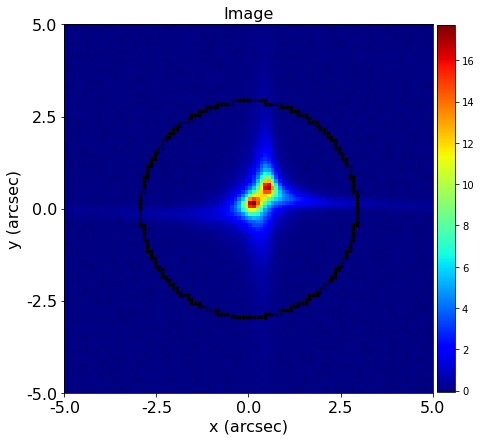

In [26]:
aplt.Imaging.image(imaging=imaging, mask=mask)

The mask automatically ‘zooms’ our plot around the masked region only - meaning that if our image is very large, we focus-in on the lens and source galaxies.

You’ll see this is an option for pretty much every Plotter in PyAutoLens, and is something we’ll do often throughout the tutorials.

To fit the data we create a MaskedImaging object, which is a ‘package’ of all parts of a data-set we need in order to fit it with a lens model:

    The imaging-data, including the image, PSF (so that when we compare a tracer’s image to the image instrument we can include blurring due to the telescope optics) and noise-map (so our goodness-of-fit measure accounts for noise in the observations).
    The mask, so that only the regions of the image with a signal are fitted.
    A Grid aligned to the Imaging data’s pixels, so the tracer’s image is generated on the same (masked) Grid as the image.


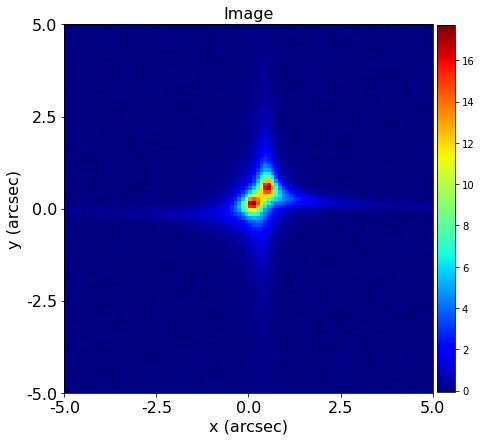

In [27]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.image(imaging=masked_imaging.imaging)

By printing its attributes, we can see that it does indeed contain the mask, masked image, masked noise-map, psf and so on.

In [28]:
print("Mask")
print(masked_imaging.mask)
print()
print("Masked Image:")
print(masked_imaging.image)
print()
print("Masked Noise-Map:")
print(masked_imaging.noise_map)
print()
print("PSF:")
print(masked_imaging.psf)
print()

Mask
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Masked Image:
[0.02501202 0.01891239 0.03868352 ... 0.16411522 0.21719313 0.16125657]

Masked Noise-Map:
[0.0204134  0.01990916 0.02150066 ... 0.02967127 0.03251631 0.02951026]

PSF:
[2.21033495e-12 1.98968011e-10 6.58891561e-09 8.02694246e-08
 3.59742603e-07 5.93115282e-07 3.59742603e-07 8.02694246e-08
 6.58891561e-09 1.98968011e-10 2.21033495e-12 1.98968011e-10
 1.79105296e-08 5.93115282e-07 7.22562334e-06 3.23829971e-05
 5.33905362e-05 3.23829971e-05 7.22562334e-06 5.93115282e-07
 1.79105296e-08 1.98968011e-10 6.58891561e-09 5.93115282e-07
 1.96412806e-05 2.39279782e-04 1.07237759e-03 1.76805174e-03
 1.07237759e-03 2.39279782e-04 1.96412806e-05 5.93115282e-07
 6.58891561e-09 8.02694246e-08 7.22562334e-06 2.39279782e-0

To fit an image, create an image using a Tracer. Lets use the same Tracer we simulated the Imaging instrument with (thus, our fit is ‘perfect’).

Its worth noting that below, we use the masked imaging’s Grid to setup the Tracer. This ensures that our image-plane image is the same resolution and alignment as our lens data’s masked image.

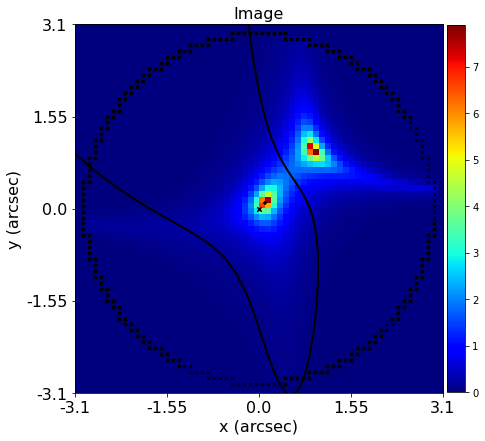

In [29]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.PointMass2(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

aplt.Tracer.image(tracer=tracer, grid=masked_imaging.grid)

To fit the image, we pass the MaskedImaging and Tracer to a FitImaging object. This performs the following:

1) Blurs the tracer's image with the lens data's PSF, ensuring the telescope optics are included in the fit. This
creates the fit's 'model_image'.

2) Computes the difference between this model_image and the observed image-data, creating the fit's 'residual_map'.

3) Divides the residual-map by the noise-map, creating the fit's 'normalized_residual_map'.

4) Squares every value in the normalized residual-map, creating the fit's 'chi_squared_map'.

5) Sums up these chi-squared values and converts them to a 'log_likelihood', which quantifies how good the tracer's
   fit to the data was (higher log_likelihood = better fit).


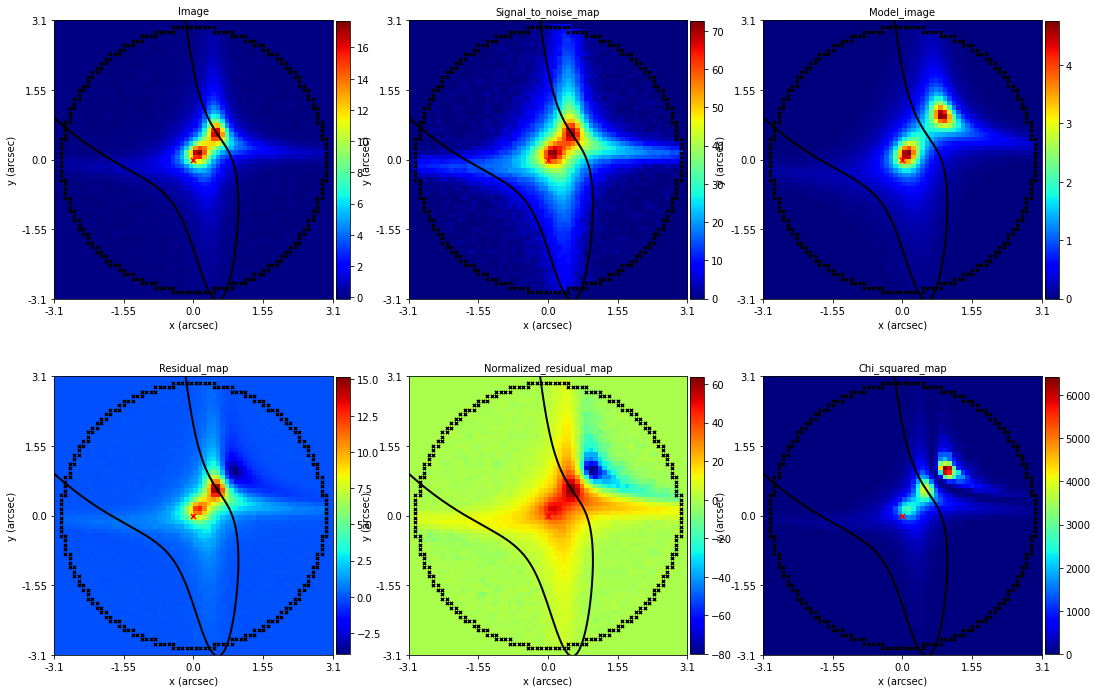

In [30]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))



The fit also gives a log likelihood, which is a single-figure estimate of how good the model image fitted the simulated image (in unmasked pixels only!).

In [31]:
print("Likelihood:")
print(fit.log_likelihood)

Likelihood:
-186853.27087353443


We used the same Tracer to create and fit the image, giving an excellent fit. The residual-map and chi-squared-map, show no signs of the source-galaxy’s light present, indicating a good fit. This solution will translate to one of the highest-log_likelihood solutions possible.

Lets change the Tracer, so that it’s near the correct solution, but slightly off. Below, we slightly offset the lens galaxy, by 0.005

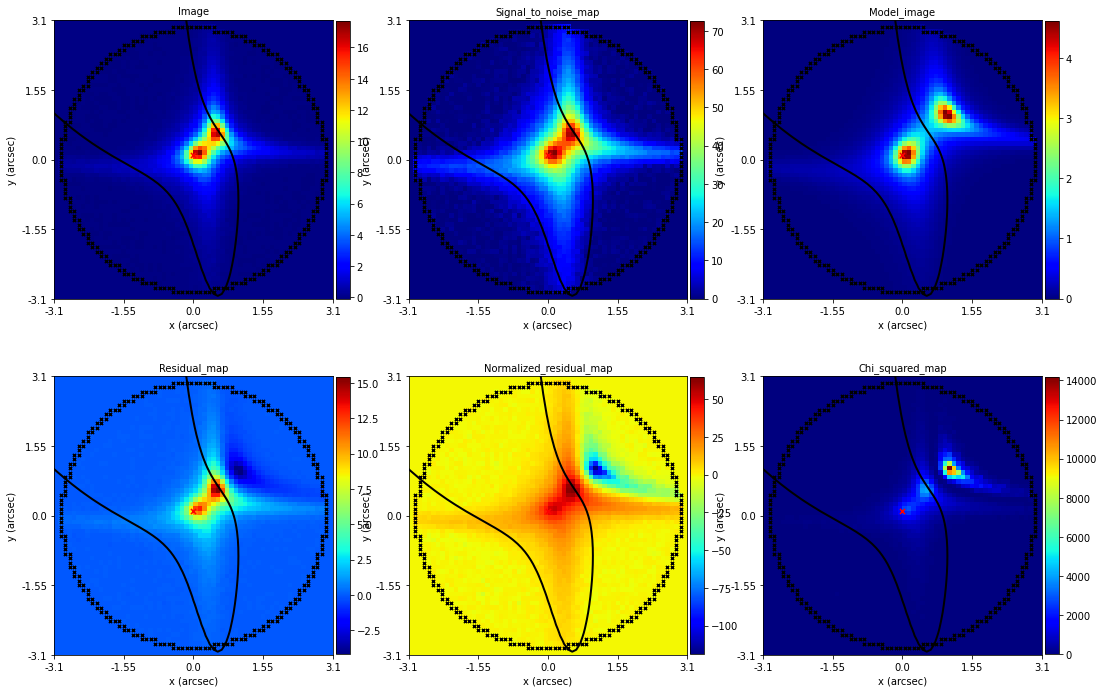

In [37]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.PointMass2(
        centre=(0.1, 0.),
        einstein_radius=6,
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))

Residuals now appear at the locations of the source galaxy, increasing the chi-squared values (which determine our log_likelihood).

Lets compare the log likelihood to the value we computed above.

In [38]:
print("Previous Likelihood:")
print(-186853.27087353443)
print("New Likelihood:")
print(fit.log_likelihood)


Previous Likelihood:
-186853.27087353443
New Likelihood:
-240952.6213924089
